In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import spotify_keys as keys # Personal keys for Spotify

# 1. Importing and Exploring the Data Set

In [110]:
df = pd.read_csv(r'df_audio_features_5000.csv')
df.columns = df.columns.str.replace(' ', '')
df_id = df[~df.index.duplicated()][['name','id']]

df_h = df.columns.values.tolist()
df_f = df.drop(['artist','duration_ms','time_signature','id','html','type'], axis = 1)
df_f.set_index(['name'], inplace=True)
df = df_f[~df_f.index.duplicated()]

# feature selection
df_f_1 = df[['danceability','energy','acousticness','tempo']]
df_f_1








,danceability,energy,acousticness,tempo
name,,,,
Se Eu Quiser Falar Com Deus,0.6580,0.25900,0.694,110.376
Saudade De Bahia,0.7420,0.39900,0.217,125.039
"Canta Canta, Minha Gente",0.8510,0.73000,0.453,93.698
Mulher Eu Sei,0.7050,0.05020,0.879,106.802
Rosa Morena,0.6510,0.11900,0.916,120.941
...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",0.2020,0.06940,0.917,87.906
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",0.1880,0.10100,0.855,83.134
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",0.0596,0.00093,0.951,71.573


<Figure size 1920x1440 with 0 Axes>

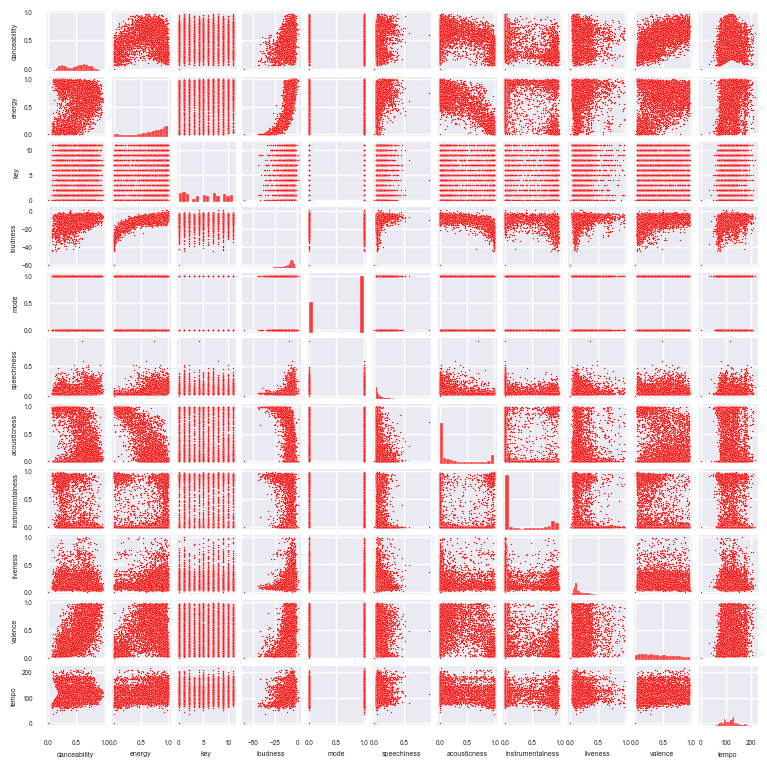

In [4]:
# visualizing complete data, mainly to understand the feature correlation
cols = df.columns.values.tolist()

dpi = 300
fig = plt.figure(dpi=dpi)
sns.set(font_scale=0.42)
scatter_settings = {'s': 1,'color': 'red'}
diag_settings = {'color': 'red'}

pairplot = sns.pairplot(df[cols], height=0.7,plot_kws=scatter_settings, diag_kws=diag_settings)

#pairplot.savefig('songs_5000_pairplot.png');

<Figure size 1920x1440 with 0 Axes>

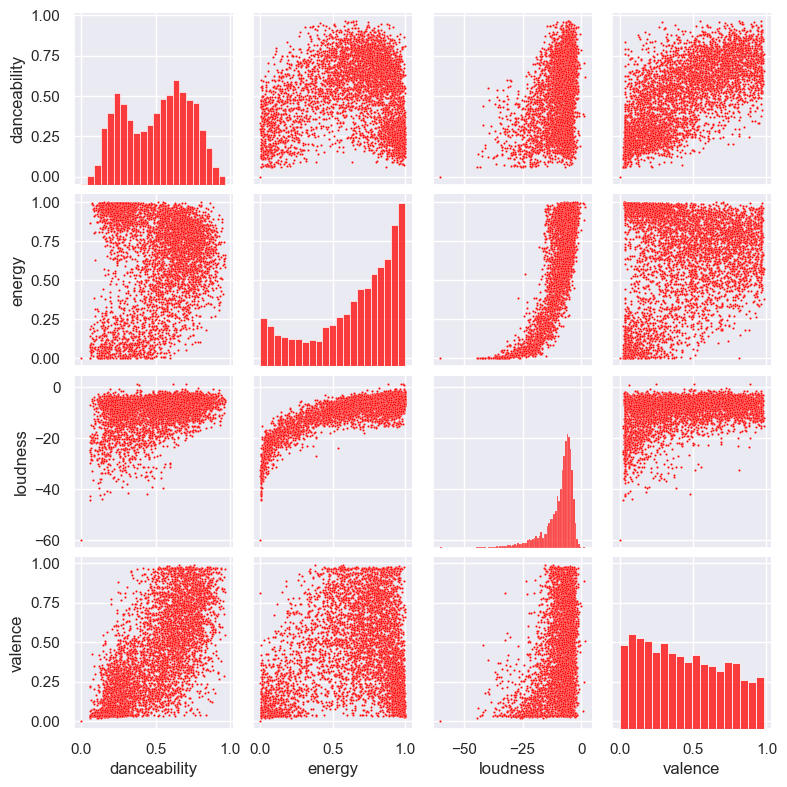

In [5]:
# visualizing selected data that has correlation, feature selection
cols = ['danceability', 'energy', 'loudness', 'valence']

dpi = 300
fig = plt.figure(dpi=dpi)
sns.set(font_scale=1)
scatter_settings = {'s': 2.5,'color': 'red'}
diag_settings = {'color': 'red'}

pairplot = sns.pairplot(df[cols], height=2,plot_kws=scatter_settings, diag_kws=diag_settings)

#pairplot.savefig('songs_5000_pairplot_feature_selection.png');

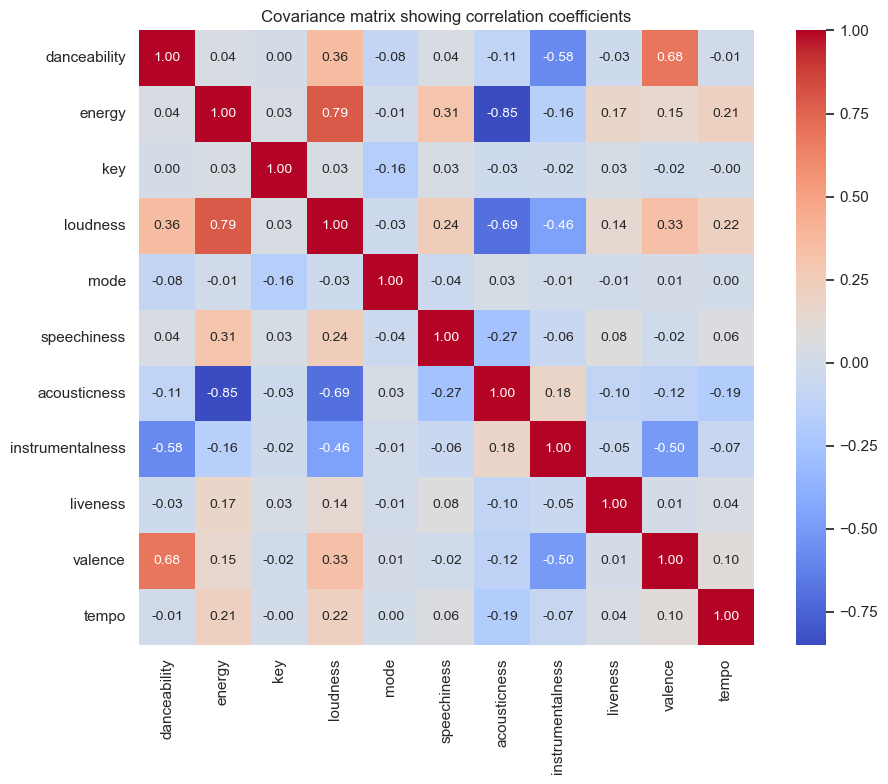

In [6]:
# plotting covariance matrix
cols = df.columns.values.tolist()
X_std = StandardScaler().fit_transform(df[cols].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(10,8))
sns.set(font_scale=1)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients', size = 12)
plt.tight_layout()
plt.show()

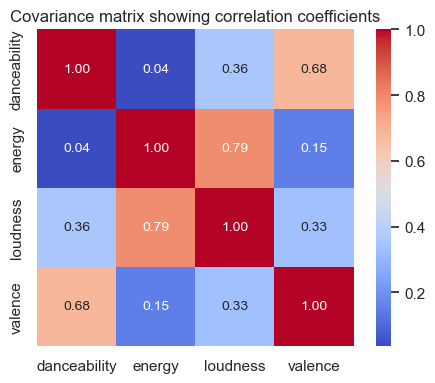

In [152]:
# plotting covariance matrix of selected features
cols = ['danceability', 'energy', 'loudness', 'valence']
X_std = StandardScaler().fit_transform(df[cols].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(5,4))
sns.set(font_scale=1)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients', size = 12)
plt.tight_layout()
plt.show()

# 2. Data Preprocessing

In [107]:
# applying Standard Scaler to the dataframe for standardizig the data
cols = df.columns.values.tolist()
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df[cols])

# 3. Performing Dimensionality Reduction with PCA

In [9]:
#  fitting standardized data using PCA
pca = PCA()
pca.fit(segmentation_std)

PCA()

In [10]:
pca.explained_variance_ratio_

array([0.29132659, 0.17130282, 0.10669884, 0.08809738, 0.08605242,
       0.0774282 , 0.07492979, 0.04700344, 0.02693137, 0.02182808,
       0.00840108])

Text(0, 0.5, 'Cumulative Explained Variance')

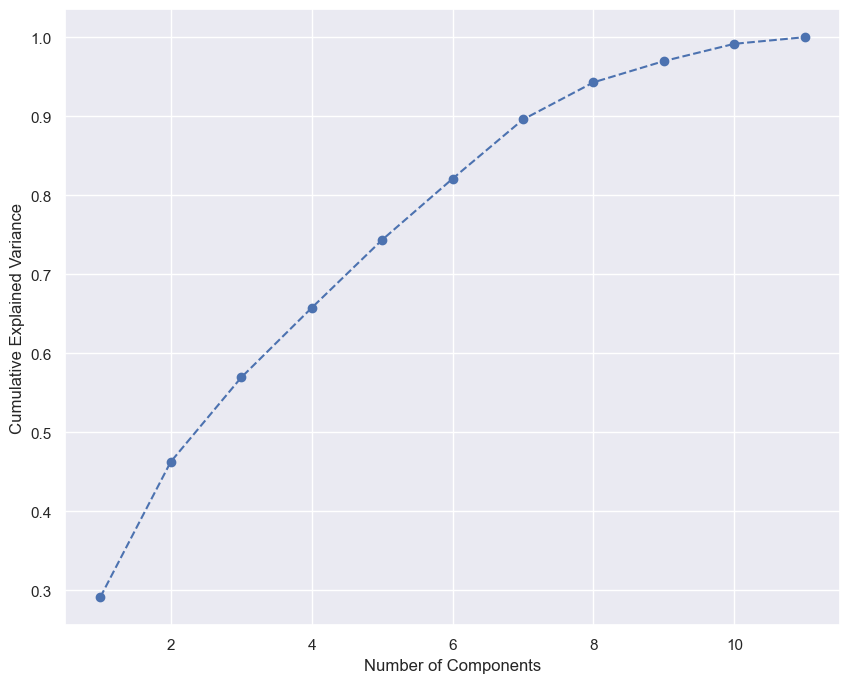

In [11]:
# deciding how many features to keep based on the cumulative variance plot
max_r = len(cols)+1
plt.figure(figsize = (10,8))
plt.plot(range(1,max_r), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# in this case, to preserve around 80 % of the variance (as rule of thumb we must preserve around 80 %) we must keep 6 components


In [23]:
# choosing 2 components, 2 seems to be right choice from above graph
n_components = 6
pca = PCA(n_components)
# fitting the data with selected number of components
pca.fit(segmentation_std)

PCA(n_components=6)

In [15]:
# calculating resulting components scores for the elements in the data set
pca.transform(segmentation_std)

array([[ 0.58506356, -0.64203616,  2.61724258,  4.78048012, -2.30605949,
         0.58675292],
       [-0.05883477, -1.82012682, -1.20635657, -0.36225189, -0.13148546,
         0.06585362],
       [-1.46151776, -1.30704112, -0.58078513,  0.62930735,  2.56544456,
         1.96404116],
       ...,
       [ 6.60257175,  0.18646604,  0.54901461,  0.23128564,  0.60241138,
        -0.83013293],
       [ 4.91952457, -0.27460591, -0.42834134,  0.58617883,  0.96558935,
        -0.34664179],
       [ 3.758677  , -0.83424202, -0.15966734,  1.5996962 ,  0.59245844,
        -0.51480268]])

In [16]:
scores_pca = pca.transform(segmentation_std)


# 4. Combining PCA and K-means Clustering

In [17]:
# determining the number of clusters keep
# fitting k means using transformed data from the PCA
wcss = []
for i in range(1,100):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 123)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

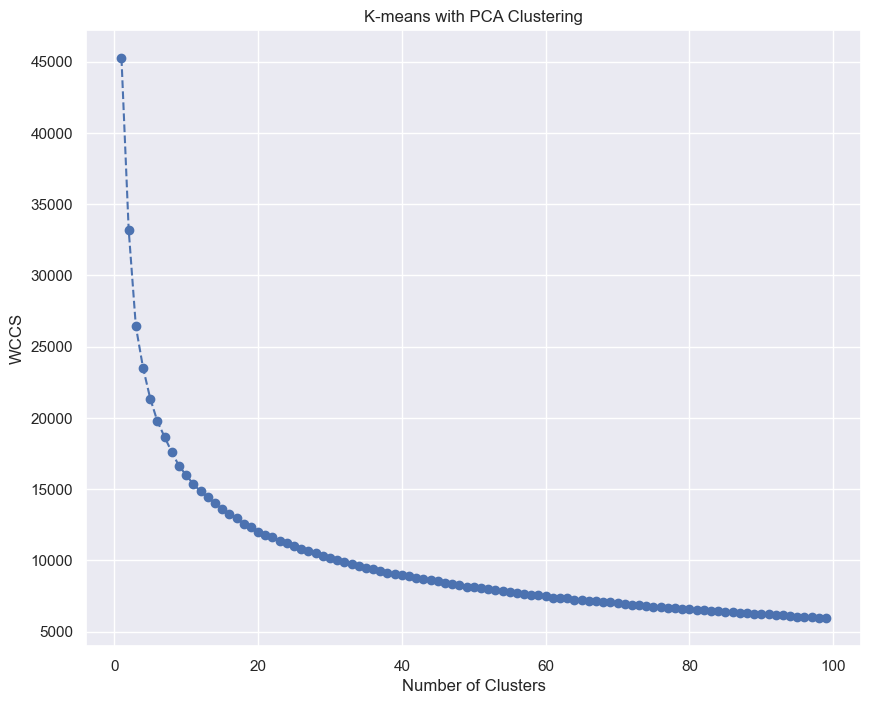

In [18]:
plt.figure(figsize = (10,8))
plt.plot(range(1,100), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCCS')
plt.title('K-means with PCA Clustering')
plt.show()
# the approach consists of looking for a kink or elbow in the WCSS graph. 
# usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. 
# in this instance, the kink comes at some where around 20 clusters mark.

In [20]:
# running K-mans with number of clusters 20
# same initializer and random state as before

kmeans_pca = KMeans(n_clusters = 20, init = 'k-means++', random_state = 123)

In [21]:
# fitting data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=20, random_state=123)

# 5. Analyzing the Results of PCA and K-Means Clustering

In [70]:
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = False), pd.DataFrame(scores_pca)], axis = 1)

df_segm_pca_kmeans.set_index(['name'], inplace=True)
df_segm_pca_kmeans
df_segm_pca_kmeans.columns.values[-n_components:] = [f'Component_{i}' for i in range(1,n_components+1)]
df_segm_pca_kmeans
# adding cluster number
df_segm_pca_kmeans['Cluster'] = kmeans_pca.labels_+1
df_segm_pca_kmeans.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Cluster
name,,,,,,,,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,0.585064,-0.642036,2.617243,4.780480,-2.306059,0.586753,18
Saudade De Bahia,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,-0.058835,-1.820127,-1.206357,-0.362252,-0.131485,0.065854,17
"Canta Canta, Minha Gente",0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,-1.461518,-1.307041,-0.580785,0.629307,2.565445,1.964041,19
Mulher Eu Sei,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,1.819298,-2.334600,-0.429427,1.802431,-0.636827,0.339002,14
Rosa Morena,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,2.218582,-2.180267,-0.253981,-0.095043,-0.436319,-0.123366,14


In [35]:
#df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'first',
                                                                               #1:'second',
                                                                               #2:'third',
                                                                               #3:'fourth'})
#filter = df_segm_pca_kmeans['Segment'] == 'third'
df_segm_pca_kmeans.head(4)#[filter]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Cluster
name,,,,,,,,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,0.585064,-0.642036,2.617243,4.780480,-2.306059,0.586753,17
Saudade De Bahia,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,-0.058835,-1.820127,-1.206357,-0.362252,-0.131485,0.065854,16
"Canta Canta, Minha Gente",0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,-1.461518,-1.307041,-0.580785,0.629307,2.565445,1.964041,18
Mulher Eu Sei,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,1.819298,-2.334600,-0.429427,1.802431,-0.636827,0.339002,13


# 6. Visualizing Clusters by Components 

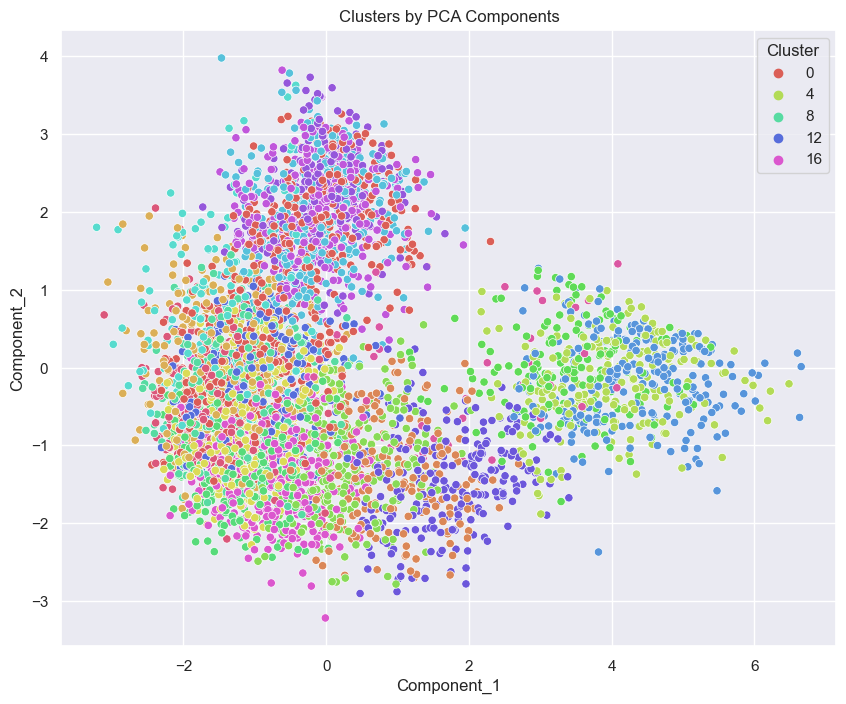

In [38]:
x_axis = df_segm_pca_kmeans['Component_1']
y_axis = df_segm_pca_kmeans['Component_2']
plt.figure(figsize = (10,8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Cluster'], palette = 'hls')
plt.title('Clusters by PCA Components')
plt.show()

In [ ]:
x_axis = df_segm_pca_kmeans['Component_1']
y_axis = df_segm_pca_kmeans['Component_2']
plt.figure(figsize = (10,8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Cluster'], palette = 'hls')
plt.title('Clusters by PCA Components')
plt.show()

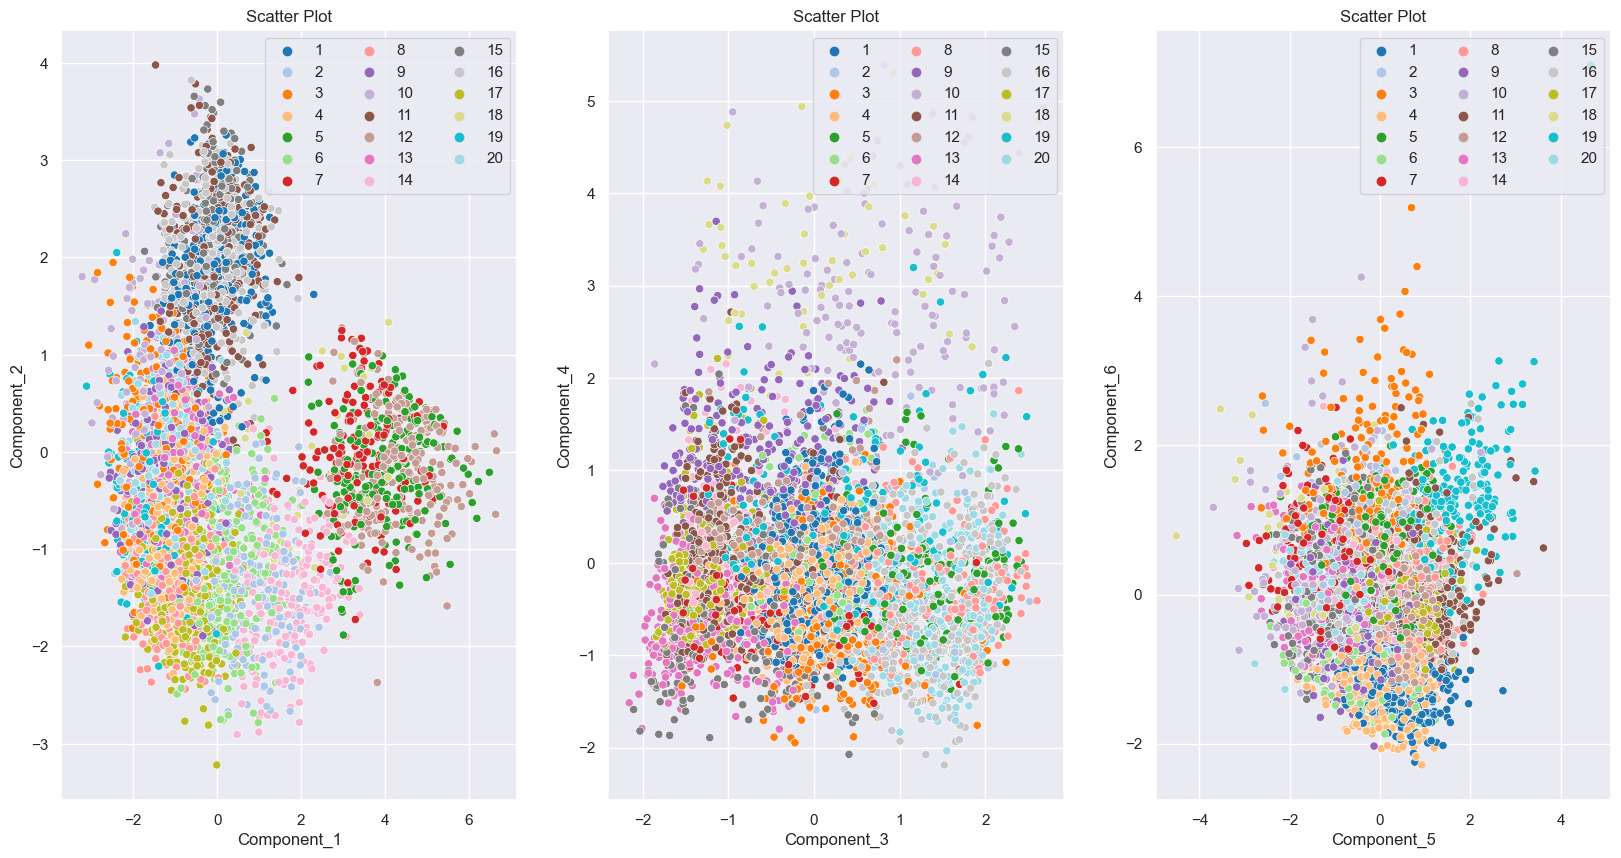

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
c_1 = df_segm_pca_kmeans['Component_1']
c_2 = df_segm_pca_kmeans['Component_2']
c_3 = df_segm_pca_kmeans['Component_3']
c_4 = df_segm_pca_kmeans['Component_4']
c_5 = df_segm_pca_kmeans['Component_5']
c_6 = df_segm_pca_kmeans['Component_6']
c = df_segm_pca_kmeans['Cluster']

# plot scatter plot on the first subplot
sns.scatterplot(x=c_1, y=c_2,hue = c, ax=ax1, palette = 'tab20')
ax1.set_title('Scatter Plot')
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
# plot histogram on the second subplot
sns.scatterplot(x=c_3, y=c_4,hue = c, ax=ax2, palette = 'tab20')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
ax2.set_title('Scatter Plot')

# plot histogram on the thrid subplot
sns.scatterplot(x=c_5, y=c_6,hue = c, ax=ax3, palette = 'tab20')
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
ax3.set_title('Scatter Plot')

# display the plot
plt.show()


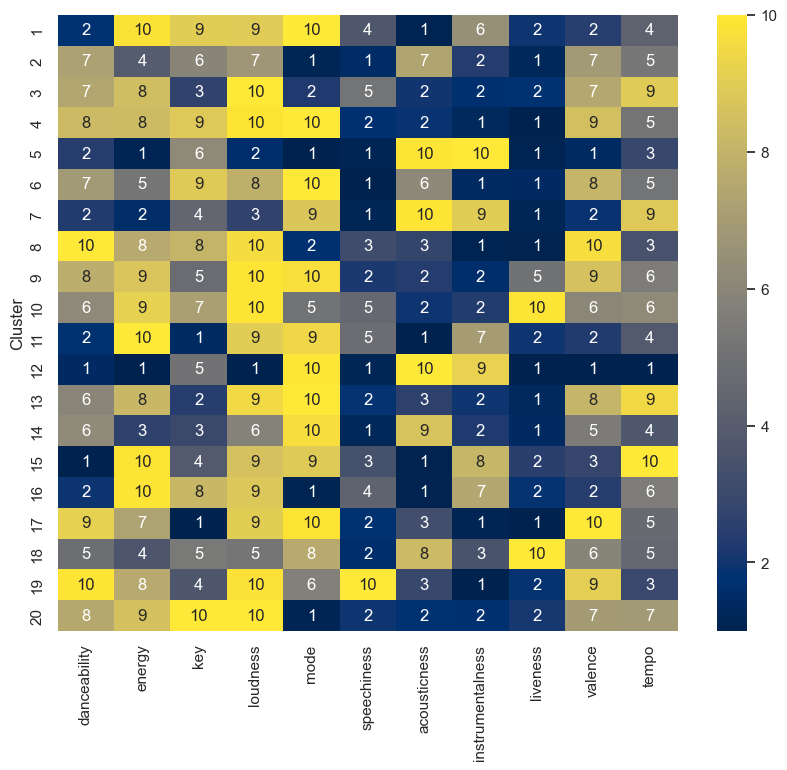

In [151]:
cols_1 = df.columns.values.tolist()
cols_1.append('Cluster')
df_cluster = df_cluster.reset_index(drop = True)
df_cluster = df_cluster[cols_1]
df_cluster
df_cluster_group = df_cluster.groupby('Cluster').mean()
#df_cluster = df_cluster.groupby(level=0).mean()
#df_cluster
df_sk_pre_1 = MinMaxScaler(feature_range=(1, 10)).fit_transform(df_cluster_group)
#df_sk_pre_1
df_sk_pre_1 = pd.DataFrame(df_sk_pre_1, columns=df_cluster_group.columns, index=df_cluster_group.index)
#display(df_sk_pre_1)
#plt.subplots(figsize=(12, 8))
plt.figure(figsize = (10,8))
sns.heatmap(df_sk_pre_1,annot=True,fmt='.0f',cmap='cividis');




In [40]:
merged_df = pd.merge(df_segm_pca_kmeans, df_id, on='name')


In [41]:
merged_df


,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Component 1,Component 2,Cluster,id
0,Se Eu Quiser Falar Com Deus ...,0.6580,0.25900,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,0.891551,1.176020,4,1n7JnwviZ7zf0LR1tcGFq7
1,Saudade De Bahia ...,0.7420,0.39900,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,-0.233737,1.728360,8,5QGM1U0eCYrQuwSJwTm5Zq
2,"Canta Canta, Minha Gente ...",0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,-1.510354,1.585542,3,0NLIFSZxPzQhCwnkn5PJYs
3,"Canta Canta, Minha Gente ...",0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,-1.510354,1.585542,3,57E1ka54d8zrIy0VzE1EAV
4,Mulher Eu Sei ...,0.7050,0.05020,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,1.196598,2.380355,4,3mXqOdlLE1k67WsAxryPFs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",0.2020,0.06940,3,-23.390,1,0.0473,0.917,0.715000,0.0832,0.0655,87.906,3.523597,0.623617,1,1aEhYlZtypmipA06SDJ4U3
5231,"Winter Fragments pour ensemble instrumental, s...",0.1880,0.10100,6,-21.873,1,0.0442,0.855,0.426000,0.0694,0.0355,83.134,3.416943,0.385719,7,1Gfqe7TAKklmuZf6hxsH6h
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",0.0596,0.00093,9,-42.959,1,0.0434,0.951,0.969000,0.0772,0.0344,71.573,5.780520,1.484920,1,2XNwnFrdMDpismp0VUZ7cU
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",0.1330,0.02080,4,-29.443,1,0.0419,0.883,0.505000,0.1110,0.0591,67.109,4.312836,0.890789,1,7ucDwgMtE3YJtEfTbuRhy0


In [27]:
merged_df.loc[0:2,]

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Component 1,Component 2,Cluster,id
0,All Shook Up,0.624,0.468,10,-12.162,1,0.1320,0.881,0.000006,0.144,0.952,74.139,-0.857594,-1.225214,0,5ueyLj6e6oVaTY0KQ6yLaA
1,I've Got You Under My Skin - Remastered 1998,0.585,0.247,1,-12.612,1,0.0400,0.452,0.000009,0.107,0.591,127.150,0.259266,-0.886898,0,3aEJMh1cXKEjgh52claxQp
2,Smoke Gets In Your Eyes,0.290,0.227,3,-13.060,1,0.0311,0.944,0.000079,0.617,0.224,114.278,1.597373,0.383388,3,307XEC1IUwUs9ojlEFwH7f


# 7. Adding Playlists to Spotify using Soptify Web Developer API

In [90]:
# Creating a list with cluster number and corresponding song id
merged_df_c = merged_df[['Cluster','id']]
list_df = merged_df_c.values.tolist()
#list_df = list_df[:2]
# creating empty dict, idea is to have cluster number as key and song id as values
dict_playlist = {}

# filling dict_playlist
for i in list_df:
    if i[0] not in dict_playlist:
       dict_playlist[i[0]]= [i[1]]
    else:
        dict_playlist[i[0]].append(i[1])

scope = 'playlist-modify-public'
# Set up the authentication, keys will be imported
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=keys.client_id,
                                               client_secret=keys.client_secret,
                                               redirect_uri='https://www.google.com/?client=safari',
                                               scope=scope))        
        
# creating playlist and adding songs to it in Soptify    
for i in range(len(dict_playlist)):
    if i in dict_playlist.keys():    
        playlist_name = f'5000_Songs_Playlist_{i+1}_of_{len(dict_playlist)}'
        playlist = sp.user_playlist_create(keys.user, name=playlist_name, public=True)
        track_m = []             
        for t in dict_playlist[i]:
            track_m_i = f'spotify:track:{t.strip()}'
            track_m.append(track_m_i)
        sp.user_playlist_add_tracks(keys.user, playlist_id=playlist['id'], tracks=track_m[:100])
        sp.playlist_add_items(playlist_id=playlist['id'], items=track_m[100:200])
        
